In [1]:
import torch
import pandas as pd
import json
import transformer_ee.dataloader.string_conv as string_conv
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset


In [2]:
mps_device = torch.device("mps")

In [3]:
df = pd.read_csv(
    "transformer_ee/data/2022-08-21_rnne_NC_250_fGScatter_20MeV_KE_01e8_max_trackE_cut.csv.xz"
)

with open("transformer_ee/config/input.json", "r") as f:
    input_d = json.load(f)
df


,addr.event,addr.run,addr.subRun,anye.hadE,anye.lepE,anye.longestTrackContained,anye.nuE,event.calE,event.charge,event.nHits,...,particle.dir.x,particle.dir.y,particle.dir.z,particle.energy,particle.is_shower,particle.length,particle.nHit,particle.start.x,particle.start.y,particle.start.z
0,5,20000000.0,0,-0.438477,0.344072,1,-0.094405,29512100.0,146557.0,489,...,"0.433606,-0.299923,-0.745334,-0.100157,0.860592","0.412988,0.266261,0.467823,-0.380913,0.0559675","0.800891,0.916052,0.474994,0.91917,0.50621","1,1,1,1,1","0,0,0,0,0","100.43,25.8799,26.5932,11.0404,15.4177","464,181,85,95,59","51.9666,51.4691,50.6269,44.7562,66.9639","156.068,155.983,156.273,164.204,158.957","1038.71,1038,1038.78,1062.48,1051.15"
1,6,20000000.0,0,-0.301516,0.328487,1,0.026971,26756600.0,132873.0,462,...,"0.320173,0.122375,-0.013626,0.836399","0.34598,0.60662,-0.987097,-0.533129","0.881922,0.785517,-0.159545,-0.12732","1,1,1,1","0,0,0,0","93.3543,61.5381,26.9224,21.3653","488,330,97,55","149.719,150.829,147.524,206.582","44.5685,45.8426,-10.5539,128.474","301.744,306.293,288.325,431.556"
2,12,20000000.0,0,-0.194787,0.176983,1,-0.017804,12231200.0,60740.4,122,...,"-0.161025,-0.273467,-0.869092","-0.380543,0.935742,-0.492786","0.910636,-0.222717,-0.0429107","1,1,0","0,0,1","15.7588,20.4948,16.9874","99,82,22","-189.079,-182.94,-190.192","121.483,114.657,134.064","793.085,771.819,767.221"
3,37,20000000.0,0,-0.094064,0.207412,1,0.113348,4450590.0,22101.6,84,...,0.264789,0.421623,0.867249,1,0,36.2258,169,-362.522,97.6322,1143.62
4,42,20000000.0,0,-0.076877,0.177945,1,0.101069,6240410.0,30989.9,85,...,-0.384293,-0.368317,0.846559,1,0,21.0111,110,221.914,-329.633,456.139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106251,56,20000000.0,0,-0.332146,0.281220,1,-0.050926,8606680.0,42740.8,87,...,0.886135,-0.0809337,0.456305,1,0,71.6258,254,210.276,516.5,750.217
106252,62,20000000.0,0,0.092105,0.189184,1,0.281289,45294700.0,224934.0,838,...,"-0.270241,0.0872679,-0.48875,-0.270936,0.223895","-0.155212,-0.311609,0.871818,0.376155,0.918681","0.950199,0.946194,-0.0325164,0.88606,0.325416","0,0,1,1,0","1,1,0,0,1","184.844,20.7818,26.9364,0.926505,7.15667","1545,160,70,31,21","-29.8561,-15.2246,-23.3499,-22.857,-22.9607","58.9037,43.312,61.585,60.1301,60.1031","180.327,206.029,147.502,149.674,147.932"
106253,74,20000000.0,0,-0.489749,0.443261,1,-0.046488,36346900.0,180499.0,774,...,"0.0301336,0.171627,-0.474925,-0.542455,-0.3643...","0.487051,0.121518,0.062721,0.0878329,0.30109,0...","0.872853,0.977639,0.877789,-0.835481,0.881237,...","1,1,1,1,1,0,0,1,1","0,0,0,0,0,1,1,0,0","144.839,114.024,25.2284,24.0273,18.2976,17.542...","740,641,131,121,97,61,53,32,15","-231.454,-228.064,-232.791,-231.903,-228.267,-...","461.506,466.314,463.089,461.96,466.667,468.288...","1263.22,1281.76,1265.64,1262.13,1280.92,1241.1..."
106254,90,20000000.0,0,-0.097840,0.241838,1,0.143998,22432700.0,111401.0,316,...,"0.178269,0.570442,0.850248","-0.983571,-0.773557,0.304128","-0.0284424,0.276053,0.429633","1,0,1","0,1,0","53.0581,30.0913,23.3243","160,115,70","190.877,227.78,190.767","103.955,10.6539,104.458","587.286,606.96,587.576"


In [4]:
for particle_feature in input_d["vector"]:
    df[particle_feature] = df[particle_feature].apply(string_conv.string_to_float_list)

In [5]:
class Pandas_NC_Dataset(Dataset):
    def __init__(self, dataframe, config: dict):
        self.df = dataframe
        self.len = len(dataframe)
        self.maxpronglen = config["max_num_prongs"]
        self.vectornames = config["vector"]
        self.scalarnames = config["scalar"]
        self.targetname = config["target"]

        # calculate mean and std for normalization
        self.stat_scalar = []
        for x in self.scalarnames:
            self.stat_scalar.append([df[x].mean(), df[x].std()])
        self.stat_scalar = torch.Tensor(self.stat_scalar).T
        self.stat_scalar = self.stat_scalar[:, None, :]

        self.stat_vector = []
        for x in self.vectornames:
            _tmp = []
            for y in df[x]:
                _tmp.extend(y)
            self.stat_vector.append([np.mean(_tmp), np.std(_tmp)])
        self.stat_vector = torch.Tensor(self.stat_vector).T
        self.stat_vector = self.stat_vector[:, None, :]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        _vectorsize = len(row[self.vectornames[0]])
        _vector = torch.Tensor(row[self.vectornames]).T
        _scalar = torch.Tensor(row[self.scalarnames]).T
        _vector = (_vector - self.stat_vector[0]) / self.stat_vector[1]
        _scalar = (_scalar - self.stat_scalar[0]) / self.stat_scalar[1]

        return (
            # pad the vector to maxpronglen
            F.pad(_vector, (0, 0, 0, self.maxpronglen - _vectorsize), "constant", 0),
            # return the scalar
            _scalar,
            # return src_key_padding_mask
            F.pad(
                torch.zeros(_vectorsize, dtype=torch.bool),
                (0, self.maxpronglen - _vectorsize),
                "constant",
                1,
            ),
            torch.Tensor(row[self.targetname]),
        )

    def __len__(self):
        return self.len


In [6]:
dataset = Pandas_NC_Dataset_v2(df, input_d)

batch_size_train = 1024
batch_size_test = 1024


In [7]:
seed = 0
_indices = np.arange(len(df))
np.random.seed(seed)
np.random.shuffle(_indices)
test_size = 0.2
train_indicies = _indices[: int(len(_indices) * (1 - test_size))]
test_indicies = _indices[int(len(_indices) * (1 - test_size)) :]

In [8]:
from torch.utils.data import Subset

train_dataset = Subset(dataset, train_indicies)
test_dataset = Subset(dataset, test_indicies)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train,
                                            shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test,
                                            shuffle=False)  

In [9]:
from transformer_ee.model.transformerEncoder import Transformer_EE_v1, Transformer_EE_v2
net=Transformer_EE_v2().to(mps_device)


In [10]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [12]:
loss_list = []
epochs = 100
error_list = []

for i in range(epochs):

    net.train()  # begin training

    for (batch_idx, batch) in enumerate(trainloader):
        vector_train_batch = batch[0].to(mps_device)
        scalar_train_batch = batch[1].to(mps_device)
        mask_train_batch = batch[2].to(mps_device)
        target_train_batch = batch[3].to(mps_device)

        Netout = net.forward(vector_train_batch, scalar_train_batch, mask_train_batch)
        # This will call the forward function, usually it returns tensors.

        loss = 100 * torch.mean(
            torch.abs((Netout - target_train_batch) / target_train_batch)
        )  # regression loss

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

        loss_list.append(loss)
        if batch_idx % 10 == 0:
            # print("Epoch: {}, batch: {} Loss: {} label_loss:{}".format(i, batch_idx, loss, label_loss_))
            print("Epoch: {}, batch: {} Loss: {:0.4f}%".format(i, batch_idx, loss))


Epoch: 0, batch: 0 Loss: 48.1288%
Epoch: 0, batch: 10 Loss: 48.0340%
Epoch: 0, batch: 20 Loss: 47.2015%
Epoch: 0, batch: 30 Loss: 47.5177%
Epoch: 0, batch: 40 Loss: 51.5786%
Epoch: 0, batch: 50 Loss: 47.3380%
Epoch: 0, batch: 60 Loss: 47.3714%
Epoch: 0, batch: 70 Loss: 47.5134%
Epoch: 0, batch: 80 Loss: 48.2304%
Epoch: 1, batch: 0 Loss: 47.0766%
Epoch: 1, batch: 10 Loss: 47.1994%
Epoch: 1, batch: 20 Loss: 48.9970%
Epoch: 1, batch: 30 Loss: 45.3997%
Epoch: 1, batch: 40 Loss: 50.5182%
Epoch: 1, batch: 50 Loss: 47.1869%
Epoch: 1, batch: 60 Loss: 47.5437%
Epoch: 1, batch: 70 Loss: 49.3566%
Epoch: 1, batch: 80 Loss: 47.6822%
Epoch: 2, batch: 0 Loss: 47.4235%
Epoch: 2, batch: 10 Loss: 47.6955%
Epoch: 2, batch: 20 Loss: 47.1979%
Epoch: 2, batch: 30 Loss: 45.8761%
Epoch: 2, batch: 40 Loss: 47.5691%
Epoch: 2, batch: 50 Loss: 50.0410%
Epoch: 2, batch: 60 Loss: 49.2465%
Epoch: 2, batch: 70 Loss: 46.9424%
Epoch: 2, batch: 80 Loss: 48.2144%
Epoch: 3, batch: 0 Loss: 47.7037%
Epoch: 3, batch: 10 Loss

KeyboardInterrupt: 

In [13]:
torch.save(net.state_dict(), "transformer_ee/model/transformer_ee_v2.pt")


In [11]:
from transformer_ee.model.transformerEncoder import Transformer_EE_v1

net=Transformer_EE_v2().to(mps_device)
net.load_state_dict(torch.load("transformer_ee/model/transformer_ee_v2.pt"))
net.eval()

Transformer_EE_v2(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
        )
        (linear1): Linear(in_features=12, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=12, bias=True)
        (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
        )
        (linear1): Linear(in_features=12, out_features=2048, bias=True)
        (dropout): Dropout(

mean resolution:  0.021785613
std resolution:  0.47382367


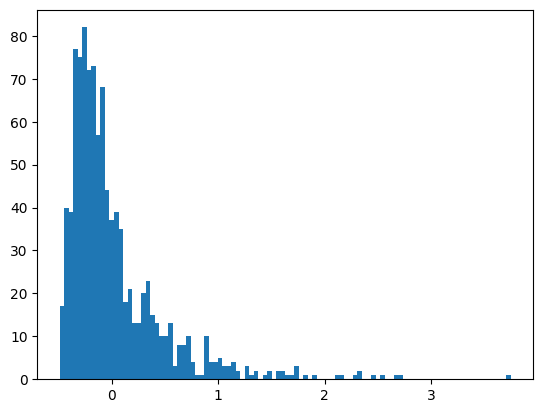

Transformer_EE_v2(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
        )
        (linear1): Linear(in_features=12, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=12, bias=True)
        (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
        )
        (linear1): Linear(in_features=12, out_features=2048, bias=True)
        (dropout): Dropout(

In [15]:
net.eval()
net.to(mps_device)
a, b, c, d=next(iter(testloader))
net.cpu()
e=net.forward(a, b, c) 
from matplotlib import pyplot as plt
numpyd=d[:, 0].cpu().detach().numpy()
numpye=e[:, 0].cpu().detach().numpy()
resolution=(numpye-numpyd)/numpyd
print("mean resolution: ", np.mean(resolution))
print("std resolution: ", np.std(resolution))
plt.hist((numpye-numpyd)/numpyd, bins=100)
plt.show()
net.to(mps_device)

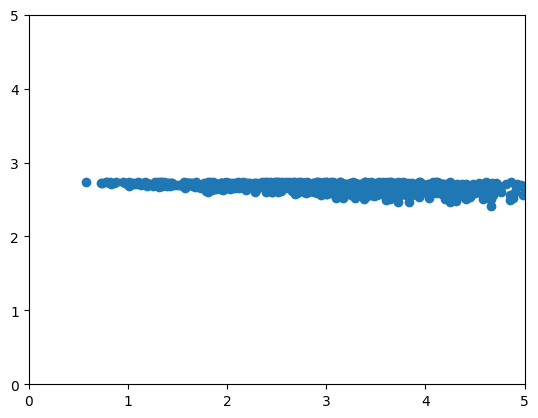

In [16]:
from matplotlib import pyplot as plt
plt.scatter(numpyd, numpye)
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.show()

array([[<AxesSubplot: xlabel='event.calE', ylabel='event.calE'>,
        <AxesSubplot: xlabel='event.charge', ylabel='event.calE'>,
        <AxesSubplot: xlabel='event.nHits', ylabel='event.calE'>,
        <AxesSubplot: xlabel='mc.nuE', ylabel='event.calE'>],
       [<AxesSubplot: xlabel='event.calE', ylabel='event.charge'>,
        <AxesSubplot: xlabel='event.charge', ylabel='event.charge'>,
        <AxesSubplot: xlabel='event.nHits', ylabel='event.charge'>,
        <AxesSubplot: xlabel='mc.nuE', ylabel='event.charge'>],
       [<AxesSubplot: xlabel='event.calE', ylabel='event.nHits'>,
        <AxesSubplot: xlabel='event.charge', ylabel='event.nHits'>,
        <AxesSubplot: xlabel='event.nHits', ylabel='event.nHits'>,
        <AxesSubplot: xlabel='mc.nuE', ylabel='event.nHits'>],
       [<AxesSubplot: xlabel='event.calE', ylabel='mc.nuE'>,
        <AxesSubplot: xlabel='event.charge', ylabel='mc.nuE'>,
        <AxesSubplot: xlabel='event.nHits', ylabel='mc.nuE'>,
        <AxesSubplot: 

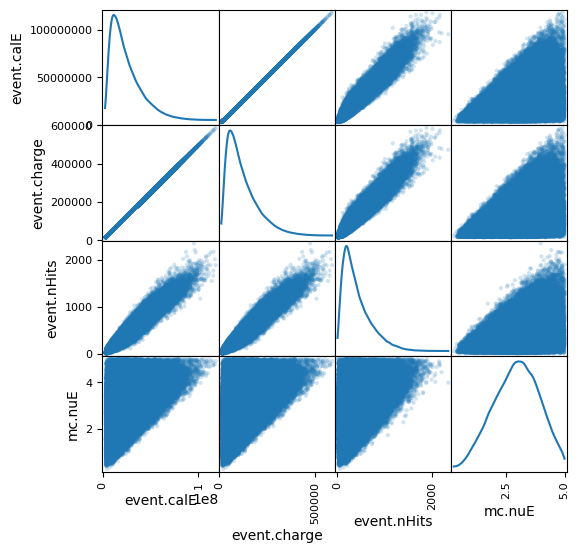

In [19]:
from pandas.plotting import scatter_matrix
scatter_matrix(df[["event.calE",
        "event.charge",
        "event.nHits",
        "mc.nuE"]], alpha = 0.2, figsize = (6, 6), diagonal = 'kde')
